In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint    
import seaborn as sns

%matplotlib inline

# Pull Data

In [134]:
path = "C:/Users/Akis-/OneDrive/Masters/Web Economics/Data/"
#test_df = pd.read_csv(path+'test.csv')
#train_df = pd.read_csv(path+'train.csv')
validation_df = pd.read_csv(path+'validation.csv')
train_df = pd.read_csv(path+'validation.csv')

In [135]:
#TotalImpressions = test_df.shape[0]
#print("TotalImpressions:",TotalImpressions)


In [136]:
#budget=6250*1000
#print("Our Budget is:",budget, "Fen")
#print("To use over",test_df.shape[0],"bid opportunities.")
#BudPerBid=budget/test_df.shape[0]
#print("Budget / Bid Opportunity:",BudPerBid)

minBid=np.min(train_df["payprice"].values)
maxBid=np.max(train_df["payprice"].values)
custRange = np.arange(minBid+1, maxBid+5,10) # determines the range that bids should be in
#custRange = np.arange(60, 65,1)

In [137]:
pd.set_option('display.max_columns', None)

# Functions

### Plot Metrics for bound combination for random bidding strategy

In [138]:
def plotResults(Matrix):

    ax = sns.heatmap(Matrix, linewidth=0, xticklabels=custRange, yticklabels=custRange[::-1], cmap="Greens") #, annot=True
    ax.set(xlabel='lower bound for random bid', ylabel='upper bound for random bid', title="Clicks by bounded random bids")
    for label in ax.xaxis.get_ticklabels()[::1]:
        label.set_visible(False)
    for label in ax.xaxis.get_ticklabels()[::1]:
        label.set_visible(True)
    for label in ax.yaxis.get_ticklabels()[::1]:
        label.set_visible(False)
    for label in ax.yaxis.get_ticklabels()[::1]:
        label.set_visible(True)
    plt.savefig('RandomBidResults.png')
    plt.show()
    
    useless = 0
    return useless

### Build Matrix containing CTR for various bound combinations

In [139]:
def BuildCTRMatrix(dataframe,plot,repeats):
    lastInRange = custRange[len(custRange)-1:][0]+1
    for n in range(0,repeats,1):
        dataSubset = dataframe.sample(frac=0.5, replace=False)
        print(n+1,"/",repeats,"...")
        for minimumBid in custRange:
            for maximumBid in range(minimumBid,lastInRange,1): #maxBid>minBid?????
                    Clicks = EvalRandBid(dataSubset,minimumBid, maximumBid,6250000,validation_df.shape[0])[1]
                    CTRMatrix[minimumBid][maximumBid]=(CTRMatrix[minimumBid][maximumBid]*n+Clicks)/(n+1)
   
    return CTRMatrix

### Extract best Bounds from Results Matrix

In [140]:
def FindBestBounds(ResultsMatrix):
    print("Best CTR is:",ResultsMatrix.values.max())
    for x in custRange:
        for y in custRange:
            if ResultsMatrix[x][y]==ResultsMatrix.values.max():
                print("X:",x,"Y:",y)
                lowerBound=x
                upperBound=y
    return lowerBound, upperBound

### Evaluate a random bid value on a new set

In [141]:
#def EvalRandBid(dataframe,lowerBound, upperBound):
#    
#    dataframe['ConstBid'] = np.random.randint(lowerBound, upperBound+1, dataframe.shape[0])
#
#    trueValues = (dataframe["payprice"]<dataframe['ConstBid'])
#    impressions = dataframe[trueValues].shape[0]
#    clicks = np.sum(dataframe[trueValues]["click"].values)
#    ClickThroughRate=(clicks*100)/impressions
#        
#    return ClickThroughRate

In [142]:
def EvalRandBid(dataframe,lowerBound, upperBound,budget,size):
    
    AdjustedBudget=(budget/size)*dataframe.shape[0]
    #print("AdjustedBudget is:",AdjustedBudget)
    tempData=dataframe
    #tempData['ConstBid']=constant
    tempData['ConstBid'] = np.random.randint(lowerBound, upperBound+1, dataframe.shape[0])

    tempData['trueValues'] = np.where(tempData["payprice"]<tempData['ConstBid'],1,0)
    tempData['ModelPays'] = tempData['trueValues']*tempData['payprice']
    tempData['cumsum'] = tempData['ModelPays'].cumsum()
    lastRowToInclude = np.argmax(tempData['cumsum'].as_matrix()>AdjustedBudget)
    if lastRowToInclude==0:
        lastRowToInclude=tempData.shape[0]
    #print("lastRowToInclude",lastRowToInclude)
    
    shortData = tempData.head(lastRowToInclude).copy(True)
    trueValues = (0<shortData['ModelPays'])
    impressions = shortData[trueValues].shape[0]
    clicks = np.sum(shortData[trueValues]["click"].values)
    spend = np.sum(shortData[trueValues]["payprice"].values)
    CostPerClick = spend/clicks
    CostPerMille = spend*1000/(impressions)
    ClickThroughRate=(clicks*100)/impressions
    #print(constant, ClickThroughRate, clicks, spend, CostPerMille, CostPerClick, impressions)
    return [ClickThroughRate, clicks, spend, CostPerMille, CostPerClick, impressions]
    #return clicks


    #impressions = shortData.loc[shortData['ModelPays'] > 0].sum()
    #clicks = shortData.loc[shortData['ModelPays'] > 0 , 'click'].sum()
    #print("clicks:",clicks)

# Main Code

### Determine Best Bounds Combination from Train Set

In [127]:
zero_data = np.zeros(shape=(len(custRange),len(custRange)))
zero_data[zero_data < 1] = 0.0
CTRMatrix=pd.DataFrame(zero_data,index=reversed(custRange), columns=custRange)

In [128]:
CTRMatrix =  BuildCTRMatrix(train_df,plot=False,repeats=5)
#CTRMatrix.to_pickle("CTRMatrix.pkl")


1 / 10 ...
2 / 10 ...
3 / 10 ...
4 / 10 ...
5 / 10 ...
6 / 10 ...
7 / 10 ...
8 / 10 ...
9 / 10 ...
10 / 10 ...


In [129]:
CTRMatrix.to_csv("RandomBidResults.csv")

In [130]:
#CTRMatrix = pd.read_pickle("CTRMatrix.pkl")

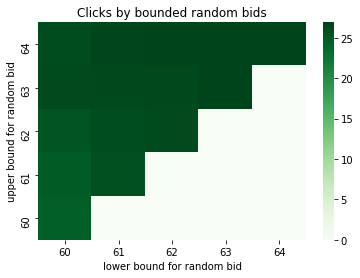

0

In [131]:
plotResults(CTRMatrix)

In [132]:
lowBound, upBound = FindBestBounds(CTRMatrix)  

Best CTR is: 26.9
X: 62 Y: 64
X: 63 Y: 63
X: 63 Y: 64
X: 64 Y: 64


### Evalute on a new data set (validation set)

In [161]:
result = EvalRandBid(validation_df,69, 89,6250000,validation_df.shape[0])

In [162]:
#constant = result[0]
ClickThroughRate = result[0]
clicks = result[1]
spend = result[2]
CostPerMille = result[3]
CostPerClick = result[4]
impressions = result[5]

#print("constant",constant)
print("ClickThroughRate",ClickThroughRate)
print("clicks",clicks)
print("spend",spend)
print("CostPerMille",CostPerMille)
print("CostPerClick",CostPerClick)
print("impressions",impressions)

ClickThroughRate 0.04623774359811241
clicks 68
spend 6249982
CostPerMille 42497.80370717909
CostPerClick 91911.5
impressions 147066


In [164]:
clicksarray = []
totalclicks = 0
for n in range(1,200,1):    
    result = EvalRandBid(validation_df,69, 89,6250000,validation_df.shape[0])
    #constant = result[0]
    ClickThroughRate = result[0]
    clicks = result[1]
    spend = result[2]
    CostPerMille = result[3]
    CostPerClick = result[4]
    impressions = result[5]

    #print("constant",constant)
    #print("clicks",clicks)
    totalclicks+=clicks
    clicksarray.append(clicks)

Average won: 135.21212121212122


In [166]:
print("Average won:",totalclicks/199)

Average won: 67.26633165829146


In [169]:
np.std(clicksarray)
np.mean(clicksarray)

2.820317903345725